In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. 数据加载与预处理工具
# ==========================================

def load_features(npz_file, features):
    """从npz加载数据并提取指定特征为DataFrame"""
    print(f"Loading: {npz_file}")
    data = np.load(npz_file, allow_pickle=True)
    # 转换为DataFrame以便按列名索引
    df = pd.DataFrame(data["params"], columns=data["param_names"])
    
    # 检查特征是否存在
    missing = [f for f in features if f not in df.columns]
    if missing:
        raise ValueError(f"Missing features in {npz_file}: {missing}")
        
    return df[features].copy()

def prepare_data(sig_file, bkg_file, test_files_dict, features, test_size=0.2, seed=42):
    """准备训练、验证和测试数据"""
    # 1. 加载训练数据 (Signal & Background)
    df_sig = load_features(sig_file, features)
    df_bkg = load_features(bkg_file, features)
    
    # 创建 Label
    y_sig = np.ones(len(df_sig))
    y_bkg = np.zeros(len(df_bkg))
    
    # 合并
    X_all = pd.concat([df_sig, df_bkg], axis=0).values
    y_all = np.concatenate([y_sig, y_bkg], axis=0)
    
    # 划分 Train / Val
    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=test_size, random_state=seed, stratify=y_all
    )
    
    # 2. 加载外部测试数据 (Test Files)
    X_tests = {}
    for name, path in test_files_dict.items():
        df_temp = load_features(path, features)
        X_tests[name] = df_temp.values
        
    return X_train, y_train, X_val, y_val, X_tests

# ==========================================
# 2. 绘图函数 (带Ratio)
# ==========================================
def plot_score_distributions(val_dict, test_dict, out_dir, model_name):
    """
    val_dict: {'sig': scores, 'bkg': scores}
    test_dict: {'EF': scores, 'QF': scores, ...}
    """
    os.makedirs(out_dir, exist_ok=True)
    
    # 设置分桶 (仅用于 PDF 直方图)
    bins = np.linspace(0, 1, 21)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # === 准备基准分母 (Validation Background) ===
    hist_val_bkg, _ = np.histogram(val_dict['bkg'], bins=bins, density=True)
    hist_base = hist_val_bkg.copy()
    hist_base[hist_base == 0] = np.nan
    
    # === 开始绘图 ===
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, 
                                            gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})
    
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
    
    # --- 1. 左轴：绘制 PDF (密度图) ---
    # Val Signal (PDF)
    ax_main.hist(val_dict['sig'], bins=bins, density=True, histtype='step', 
                 color='red', linestyle='--', linewidth=1.5, label='Val Sig PDF') # 实线区分
    
    # Val Background (PDF - Base)
    ax_main.hist(bins[:-1], bins, weights=hist_val_bkg, histtype='step', 
                 color='black', linestyle='--', linewidth=1.5, label='Val Bkg PDF') # 实线区分
    
    # External Test Sets (PDF)
    for i, (name, scores) in enumerate(test_dict.items()):
        color = colors[i % len(colors)]
        
        hist_curr, _ = np.histogram(scores, bins=bins, density=True)
        
        # 填充颜色的 PDF
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='stepfilled', 
                     alpha=0.3, color=color, label=f"{name} (PDF)")
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='step', 
                     linewidth=1, color=color)
        
        # Ratio Plot
        ratio = hist_curr / hist_base
        ax_ratio.step(bin_centers, ratio, where='mid', color=color, linewidth=1.5)

    # --- 2. 右轴：绘制 Smooth CDF (基于原始数据 Plot) ---
    ax_cdf = ax_main.twinx()  # 双Y轴
    
    # (A) 信号 CDF (0 -> 1)
    # 逻辑：排序数据，y轴是从 1/N 到 1
    sig_sorted = np.sort(val_dict['sig'])
    y_sig = np.arange(1, len(sig_sorted) + 1) / len(sig_sorted)
    
    ax_cdf.plot(sig_sorted, y_sig, 
                color='red', linestyle='--', alpha=0.3, linewidth=2,
                label='Val Sig CDF (0$\u2192$1)')

    # (B) 背景 Survival Function (1 -> 0)
    # 逻辑：排序数据，y轴是从 1 到 1/N (或者 1 - CDF)
    bkg_sorted = np.sort(val_dict['bkg'])
    y_bkg = 1.0 - np.arange(1, len(bkg_sorted) + 1) / len(bkg_sorted)
    
    ax_cdf.plot(bkg_sorted, y_bkg, 
                color='black', linestyle='--', alpha=0.3, linewidth=2,
                label='Val Bkg Surv (1$\u2192$0)')

    # === 设置样式 ===
    
    # 左轴 (PDF)
    # ax_main.set_yscale('log')
    ax_main.set_ylabel("Density (Log Scale)")
    ax_main.set_title(f"{model_name} Score Distributions")
    ax_main.legend(loc='upper center', ncol=2, frameon=False, fontsize=10)
    ax_main.grid(alpha=0.3)
    
    # 右轴 (CDF)
    ax_cdf.set_ylabel("Probability (CDF / Survival)")
    ax_cdf.set_ylim(0, 1.05)
    # 将 CDF 图例放在右边中间，防止遮挡
    # ax_cdf.legend(loc='center right', frameon=False, fontsize=9)
    
    # 底部 Ratio
    ax_ratio.axhline(1, color='black', linestyle='--', alpha=0.5) 
    ax_ratio.set_ylabel("Ratio / Val Bkg")
    ax_ratio.set_xlabel("Model Score (Signal Probability)")
    ax_ratio.set_ylim(0, 3) 
    ax_ratio.grid(alpha=0.3)
    
    save_path = os.path.join(out_dir, f"{model_name}_dist_ratio_smooth_cdf.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {save_path}")# ==========================================
# 3. 模型定义与运行函数
# ==========================================

# --- XGBoost ---
def run_xgboost(X_train, y_train, X_val, y_val, X_tests, out_dir):
    print("\n=== Training XGBoost ===")
    
    # 初始化模型
    clf = xgb.XGBClassifier(
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        eval_metric="logloss",
        use_label_encoder=False,
        tree_method='hist',
        device ='cpu'
    )
    
    # 训练
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # 预测
    # 获取 Signal=1 的概率
    val_probs = clf.predict_proba(X_val)[:, 1]
    
    # 分离验证集中的 Sig 和 Bkg 预测结果供画图使用
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # 预测外部测试集
    test_dict = {}
    for name, X in X_tests.items():
        test_dict[name] = clf.predict_proba(X)[:, 1]
        
    # 绘图
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="XGBoost")
    
    return clf

# --- MLP (PyTorch) ---
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim), # 加个BN防过拟合
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

def run_mlp(X_train, y_train, X_val, y_val, X_tests, out_dir, device='cuda'):
    print("\n=== Training MLP ===")
    
    # MLP 必须进行标准化 (Standard Scaling)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # 转 Tensor
    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train).unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    
    # 初始化模型
    model = SimpleMLP(in_dim=X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    
    # 简单训练循环
    epochs = 30
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # 推理
    model.eval()
    
    # 1. 处理验证集
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
        val_probs = model(X_val_tensor).cpu().numpy().flatten()
        
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # 2. 处理外部测试集
    test_dict = {}
    with torch.no_grad():
        for name, X in X_tests.items():
            # 必须使用与训练集相同的 scaler
            X_scaled = scaler.transform(X)
            X_tensor = torch.FloatTensor(X_scaled).to(device)
            test_dict[name] = model(X_tensor).cpu().numpy().flatten()
            
    # 绘图
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="MLP")
    
    return model

# ==========================================
# Main Execution
# ==========================================
if __name__ == "__main__":
    # 路径配置
    sig_file = "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose.npz"
    pr_file  = "/home/zhonghua/data/Dataset_Filted/1e10_V03/Proton_all_combined_filted_1e10_V03_12_16_dataset_loose.npz"
    
    test_files = {
        "EF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_loose.npz",
        "QF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_loose.npz",
        "Exp_2022": "/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_loose.npz"
    }
   
    
    # 特征列表 'recE',
    feature_cols = ['R_mean', 'Eage', 'rec_theta', 'rec_phi']
    output_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"
    
    device = "cpu"
    
    # 1. 准备数据
    print("Preparing data...")
    X_train, y_train, X_val, y_val, X_tests = prepare_data(
        sig_file, pr_file, test_files, feature_cols
    )
    print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}")
    
    # 2. 运行 XGBoost
    run_xgboost(X_train, y_train, X_val, y_val, X_tests, output_dir)
    
    # 3. 运行 MLP
    run_mlp(X_train, y_train, X_val, y_val, X_tests, output_dir, device=device)
    
    print("\nDone. Check output directory for plots.")


Preparing data...
Loading: /home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/1e10_V03/Proton_all_combined_filted_1e10_V03_12_16_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_loose.npz
Train size: 7480, Val size: 1870

=== Training XGBoost ===


/home/zhonghua/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:26:10] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Plot saved to /home/zhonghua/Filt_Event/model_validation/xgb_mlp/XGBoost_dist_ratio_smooth_cdf.png

=== Training MLP ===
Plot saved to /home/zhonghua/Filt_Event/model_validation/xgb_mlp/MLP_dist_ratio_smooth_cdf.png

Done. Check output directory for plots.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def load_data_columns(npz_file, features):
    """
    读取 npz 文件并仅提取需要的列
    """
    try:
        data = np.load(npz_file, allow_pickle=True)
        # 获取 param_names 并转为列表
        param_names = list(data["param_names"])
        params = data["params"]
        
        # 找到需要的列索引
        indices = []
        for f in features:
            if f in param_names:
                indices.append(param_names.index(f))
            else:
                print(f"Warning: Feature '{f}' not found in {os.path.basename(npz_file)}")
                return None
        
        # 提取数据
        selected_data = params[:, indices]
        df = pd.DataFrame(selected_data, columns=features)
        return df
    except Exception as e:
        print(f"Error loading {npz_file}: {e}")
        return None

def plot_feature_distributions(sig_file, pr_file, test_files, feature_cols, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    
    # 1. 定义所有数据源及其显示的名称和颜色
    # 格式: Name: (FilePath, Color, LineStyle)
    data_sources_config = {
        "Signal (Monopole)": (sig_file, "red", "-"),
        "Background (Proton)": (pr_file, "black", "-"),
    }
    
    # 将测试文件加入配置
    test_colors = ["blue", "green", "purple", "orange"]
    for i, (name, path) in enumerate(test_files.items()):
        color = test_colors[i % len(test_colors)]
        data_sources_config[name] = (path, color, "--") # 测试集用虚线区分

    # 2. 加载所有数据到内存
    print("Loading datasets...")
    loaded_data = {}
    for name, (path, _, _) in data_sources_config.items():
        print(f"  -> {name}")
        df = load_data_columns(path, feature_cols)
        if df is not None:
            loaded_data[name] = df

    # 3. 开始绘图 (2x3 Grid)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten() # 展平方便索引 0-5
    
    print("Plotting distributions...")
    
    for i, feature in enumerate(feature_cols):
        ax = axes[i]
        
        # 为了统一 binning，先获取该特征在所有数据集中的最大最小值
        all_values = []
        for name, df in loaded_data.items():
            all_values.append(df[feature].values)
        all_values_concat = np.concatenate(all_values)
        
        # 自动确定范围
        # 对于 recE，如果跨度太大，建议使用 log bins
        is_log_x = False
        if feature == 'recE':
            # 如果是能量，通常使用对数坐标
            min_val = np.min(all_values_concat[all_values_concat > 0]) # 避免log(0)
            max_val = np.max(all_values_concat)
            bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)
            is_log_x = True
            ax.set_xscale('log')
        else:
            min_val = np.min(all_values_concat)
            max_val = np.max(all_values_concat)
            bins = np.linspace(min_val, max_val, 50)
        
        # 循环绘制每个数据集
        for name, df in loaded_data.items():
            path, color, linestyle = data_sources_config[name]
            values = df[feature].values
            
            # 绘制直方图
            ax.hist(values, bins=bins, density=True, 
                    histtype='step', linewidth=2, 
                    color=color, linestyle=linestyle,
                    label=name)
        
        ax.set_title(f"Distribution of {feature}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")
        ax.grid(alpha=0.3)
        
        # 如果是对数坐标，最好再加个说明
        if is_log_x:
            ax.text(0.05, 0.95, "Log Scale X", transform=ax.transAxes, 
                    verticalalignment='top', fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.5))

    # 4. 处理最后一个子图 (图例 & 删除多余坐标轴)
    # 因为只有 5 个特征，axes[5] 是空的
    # 我们利用这个空位放一个大的图例，或者直接删除它把图例放在 axes[4]
    
    # 方法 A: 删除第6个图，图例放在第1个图里
    # axes[0].legend(loc='upper right', fontsize=8, framealpha=0.9)
    # fig.delaxes(axes[5])
    
    # 或者 方法 B (推荐): 把第6个图变成专门的图例区
    fig.delaxes(axes[5]) 
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.15), fontsize=12)

    plt.tight_layout()
    save_path = os.path.join(out_dir, "feature_distributions_comparison.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Done. Plot saved to {save_path}")

if __name__ == "__main__":
    # === 配置 ===
    sig_file = "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose.npz"
    pr_file  = "/home/zhonghua/data/Dataset_Filted/1e10_V03/Proton_all_combined_filted_1e10_V03_12_16_dataset_loose.npz"
    
    test_files = {
        "EF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_loose.npz",
        "QF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_loose.npz",
        "Exp_2022": "/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_loose.npz"
    }
    
    feature_cols = ['R_mean', 'Eage', 'recE',]
    output_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"

    # === 运行 ===
    plot_feature_distributions(sig_file, pr_file, test_files, feature_cols, output_dir)


Loading datasets...
  -> Signal (Monopole)
  -> Background (Proton)
  -> EF_Model
  -> QF_Model
  -> Exp_2022
Plotting distributions...
Done. Plot saved to /home/zhonghua/Filt_Event/model_validation/xgb_mlp/feature_distributions_comparison.png


In [30]:
sig_file = "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose.npz"
sig_data = np.load(sig_file, allow_pickle=True)
sig_df = pd.DataFrame(sig_data["params"], columns=sig_data["param_names"])


def filter_out_peak_data(df: pd.DataFrame, column_name: str, peak_range: tuple, max_fraction: float = 0.05):
    """
    排查并过滤 DataFrame 中某个参数在特定区间内过度集中的数据。
    
    Args:
        df (pd.DataFrame): 待处理的 DataFrame。
        column_name (str): 需要排查的参数名（如 'rec_theta'）。
        peak_range (tuple): 异常集中的区间 (min_val, max_val)。
        max_fraction (float): 如果事件数占比超过这个比例，则认为数据异常，返回过滤后的数据。
                              例如，0.05 表示如果一个很小的区间内包含了超过 5% 的数据，则认为是异常数据。
                              
    Returns:
        pd.DataFrame: 过滤后的 DataFrame。
        int: 删除的事件数。
    """
    if column_name not in df.columns:
        print(f"Warning: Column '{column_name}' not found.")
        return df, 0

    lower_bound, upper_bound = peak_range
    
    # 1. 识别位于峰值区间的数据索引
    mask_in_peak = (df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)
    
    num_total = len(df)
    num_in_peak = mask_in_peak.sum()
    fraction_in_peak = num_in_peak / num_total
    
    print(f"--- {column_name} Filter ---")
    print(f"  Total events: {num_total}")
    print(f"  Events in range {peak_range}: {num_in_peak} ({fraction_in_peak:.2%})")

    # 2. 判断是否需要删除（这里假设如果密度超过 max_fraction 就需要删除）
    if fraction_in_peak > max_fraction:
        print(f"  ✅ High concentration detected. Filtering out {num_in_peak} events.")
        # 返回不在峰值区间的数据
        df_filtered = df[~mask_in_peak].copy()
        return df_filtered, num_in_peak
    else:
        print(f"  ❌ Concentration within limit. No filtering applied.")
        return df.copy(), 0


# --- 示例应用 ---

# 假设你的 sig_df 是 red line，需要处理
# 估计峰值区域：rec_theta 集中在 0.27 到 0.29
THETA_PEAK_RANGE = (0.27, 0.29)
THETA_MAX_FRACTION = 0.05 # 允许在这个小区间内最多有 5% 的数据

# 估计峰值区域：rec_phi 集中在 0.8 到 1.2
PHI_PEAK_RANGE = (0.8, 1.2)
PHI_MAX_FRACTION = 0.05 


# 假设 sig_df 已经被加载 (来自你的上下文)
print("Processing sig_df...")
sig_df_filtered, count_theta = filter_out_peak_data(
    sig_df, 'rec_theta', THETA_PEAK_RANGE, THETA_MAX_FRACTION
)

sig_df_filtered, count_phi = filter_out_peak_data(
    sig_df_filtered, 'rec_phi', PHI_PEAK_RANGE, PHI_MAX_FRACTION
)





Processing sig_df...
--- rec_theta Filter ---
  Total events: 4366
  Events in range (0.27, 0.29): 235 (5.38%)
  ✅ High concentration detected. Filtering out 235 events.
--- rec_phi Filter ---
  Total events: 4131
  Events in range (0.8, 1.2): 403 (9.76%)
  ✅ High concentration detected. Filtering out 403 events.


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. 数据加载与预处理工具
# ==========================================

def load_full_data(npz_file):
    """
    加载完整的 npz 数据，返回包含所有 params 的 DataFrame。
    """
    print(f"Loading: {npz_file}")
    data = np.load(npz_file, allow_pickle=True)
    # 使用 param_names 作为列名构建完整 DataFrame
    df = pd.DataFrame(data["params"], columns=data["param_names"])
    return df

def prepare_data(sig_file, bkg_file, test_files_dict, features, test_size=0.2, seed=42):
    """
    准备训练、验证和测试数据。
    同时返回用于保存 CSV 的原始 DataFrame (仅 Val 和 Test，不含 Train)。
    """
    # 1. 加载完整数据
    df_sig = load_full_data(sig_file)
    df_bkg = load_full_data(bkg_file)
    
    # 检查特征是否存在
    for f in features:
        if f not in df_sig.columns:
            raise ValueError(f"Feature {f} missing in signal file")
        if f not in df_bkg.columns:
            raise ValueError(f"Feature {f} missing in background file")

    # 创建 Label
    y_sig = np.ones(len(df_sig))
    y_bkg = np.zeros(len(df_bkg))
    
    # 合并 DataFrame 和 Label
    df_all = pd.concat([df_sig, df_bkg], axis=0).reset_index(drop=True)
    y_all = np.concatenate([y_sig, y_bkg], axis=0)
    
    # 提取训练所需的特征矩阵 X
    X_all = df_all[features].values
    
    # 划分 Train / Val
    # 注意：这里我们同时划分 X(特征), y(标签) 和 df_all(原始完整数据)
    # random_state 保证了 X 和 df 的划分索引是一一对应的
    X_train, X_val, y_train, y_val, _, df_val = train_test_split(
        X_all, y_all, df_all, test_size=test_size, random_state=seed, stratify=y_all
    )
    
    # 2. 加载外部测试数据
    # test_data 结构: { 'name': (X_matrix, full_DataFrame) }
    test_data = {}
    for name, path in test_files_dict.items():
        df_temp = load_full_data(path)
        X_temp = df_temp[features].values
        test_data[name] = (X_temp, df_temp)
        
    return X_train, y_train, X_val, y_val, df_val, test_data

def save_to_csv(df_original, scores, out_dir, filename):
    """
    将原始数据与模型评分合并并保存为 CSV
    """
    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, filename)
    
    # 避免修改原始内存中的 df，创建副本
    df_save = df_original.copy()
    
    # 添加模型分数
    df_save['model_score'] = scores
    
    # 保存
    print(f"Saving CSV: {save_path}")
    df_save.to_csv(save_path, index=False, float_format='%.6g')

# ==========================================
# 2. 绘图函数 (保持不变)
# ==========================================
def plot_score_distributions(val_dict, test_dict, out_dir, model_name):
    """
    val_dict: {'sig': scores, 'bkg': scores}
    test_dict: {'EF': scores, 'QF': scores, ...}
    """
    os.makedirs(out_dir, exist_ok=True)
    
    bins = np.linspace(0, 1, 11) # 稍微增加一点bin数使其更平滑
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    hist_val_bkg, _ = np.histogram(val_dict['bkg'], bins=bins, density=True)
    hist_base = hist_val_bkg.copy()
    hist_base[hist_base == 0] = np.nan
    
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, 
                                            gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})
    
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
    
    # --- PDF ---
    ax_main.hist(val_dict['sig'], bins=bins, density=True, histtype='step', 
                 color='red', linestyle='--', linewidth=1.5, label='Val Sig PDF')
    
    ax_main.hist(bins[:-1], bins, weights=hist_val_bkg, histtype='step', 
                 color='black', linestyle='--', linewidth=1.5, label='Val Bkg PDF')
    
    for i, (name, scores) in enumerate(test_dict.items()):
        color = colors[i % len(colors)]
        hist_curr, _ = np.histogram(scores, bins=bins, density=True)
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='step', 
                     alpha=0.3, color=color, label=f"{name} (PDF)")
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='step', 
                     linewidth=1, color=color)
        
        ratio = hist_curr / hist_base
        ax_ratio.step(bin_centers, ratio, where='mid', color=color, linewidth=1.5)

    # --- CDF ---
    ax_cdf = ax_main.twinx()
    sig_sorted = np.sort(val_dict['sig'])
    y_sig = np.arange(1, len(sig_sorted) + 1) / len(sig_sorted)
    ax_cdf.plot(sig_sorted, y_sig, color='red', linestyle='--', alpha=0.3, linewidth=2, label='Val Sig CDF')

    bkg_sorted = np.sort(val_dict['bkg'])
    y_bkg = 1.0 - np.arange(1, len(bkg_sorted) + 1) / len(bkg_sorted)
    ax_cdf.plot(bkg_sorted, y_bkg, color='black', linestyle='--', alpha=0.3, linewidth=2, label='Val Bkg Surv')

    ax_main.set_ylabel("Density")
    # ax_main.set_yscale('log') # Log scale 经常更好看
    ax_main.set_title(f"{model_name} Score Distributions")
    ax_main.legend(loc='upper center', ncol=2, frameon=False, fontsize=10)
    ax_main.grid(alpha=0.3)
    
    ax_cdf.set_ylabel("Probability")
    ax_cdf.set_ylim(0, 1.05)
    
    ax_ratio.axhline(1, color='black', linestyle='--', alpha=0.5) 
    ax_ratio.set_ylabel("Ratio / Val Bkg")
    ax_ratio.set_xlabel("Model Score")
    ax_ratio.set_ylim(0, 3) 
    ax_ratio.grid(alpha=0.3)
    
    save_path = os.path.join(out_dir, f"{model_name}_dist.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {save_path}")

# ==========================================
# 3. 模型定义与运行函数
# ==========================================

# --- XGBoost ---
def run_xgboost(X_train, y_train, X_val, y_val, df_val, test_data, out_dir):
    print("\n=== Training XGBoost ===")
    
    clf = xgb.XGBClassifier(
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        eval_metric="logloss",
        use_label_encoder=False,
        tree_method='hist',
        device='cpu'
    )
    
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # --- 验证集预测与保存 ---
    val_probs = clf.predict_proba(X_val)[:, 1]
    
    # 保存 Validation CSV
    save_to_csv(df_val, val_probs, out_dir, "validation_set_xgb.csv")
    
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # --- 测试集预测与保存 ---
    test_dict = {}
    for name, (X_test, df_test) in test_data.items():
        probs = clf.predict_proba(X_test)[:, 1]
        test_dict[name] = probs
        
        # 保存 Test CSV
        csv_name = f"{name}_xgb.csv"
        save_to_csv(df_test, probs, out_dir, csv_name)
        
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="XGBoost")
    return clf

# --- MLP (PyTorch) ---
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

def run_mlp(X_train, y_train, X_val, y_val, df_val, test_data, out_dir, device='cuda'):
    print("\n=== Training MLP ===")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train).unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    
    model = SimpleMLP(in_dim=X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    
    epochs = 30
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    model.eval()
    
    # --- 验证集预测与保存 ---
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
        val_probs = model(X_val_tensor).cpu().numpy().flatten()
    
    # 保存 Validation CSV (注意：这里保存的是df_val原始值，不是scaler处理后的)
    save_to_csv(df_val, val_probs, out_dir, "validation_set_mlp.csv")
        
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # --- 测试集预测与保存 ---
    test_dict = {}
    with torch.no_grad():
        for name, (X_test, df_test) in test_data.items():
            X_test_scaled = scaler.transform(X_test)
            X_tensor = torch.FloatTensor(X_test_scaled).to(device)
            probs = model(X_tensor).cpu().numpy().flatten()
            test_dict[name] = probs
            
            # 保存 Test CSV
            csv_name = f"{name}_mlp.csv"
            save_to_csv(df_test, probs, out_dir, csv_name)
            
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="MLP")
    return model

# ==========================================
# Main Execution
# ==========================================
if __name__ == "__main__":
    # 路径配置
    sig_file = "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose.npz"
    pr_file  = "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_loose.npz"
    
    test_files = {
        "EF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_loose.npz",
        "QF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_loose.npz",
        "Exp_2022": "/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_loose_300_500.npz",
        "QG_large": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_loose_300_500.npz",
        "Monopole_large": "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose_300_500.npz",
    }
    
    # 特征列表'R_mean', 'rec_phi'
    feature_cols = ['Eage', 'rec_theta', ]
    output_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"
    
    device = "cpu" # 如果有GPU可改为 "cuda"
    
    # 1. 准备数据
    print("Preparing data...")
    # 注意：prepare_data 现在返回 df_val 和 test_data (包含完整df)
    X_train, y_train, X_val, y_val, df_val, test_data = prepare_data(
        sig_file, pr_file, test_files, feature_cols
    )
    print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}")
    
    # 2. 运行 XGBoost (会自动保存CSV)
    run_xgboost(X_train, y_train, X_val, y_val, df_val, test_data, output_dir)
    
    # # 3. 运行 MLP (会自动保存CSV)
    # run_mlp(X_train, y_train, X_val, y_val, df_val, test_data, output_dir, device=device)
    
    print("\nAll Done.")


Preparing data...
Loading: /home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_loose.npz
Loading: /home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_loose_300_500.npz
Loading: /home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_loose_300_500.npz
Loading: /home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose_300_500.npz
Train size: 6287, Val size: 1572

=== Training XGBoost ===
Saving CSV: /home/zhonghua/Filt_Event/model_validation/xgb_mlp/validation_set_xgb.csv
Saving CSV: /home/zhonghua/Filt_Event/model_validation/xgb_mlp/EF_Model_xgb.c

/home/zhonghua/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:21:47] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saving CSV: /home/zhonghua/Filt_Event/model_validation/xgb_mlp/QF_Model_xgb.csv
Saving CSV: /home/zhonghua/Filt_Event/model_validation/xgb_mlp/Exp_2022_xgb.csv
Saving CSV: /home/zhonghua/Filt_Event/model_validation/xgb_mlp/QG_large_xgb.csv
Saving CSV: /home/zhonghua/Filt_Event/model_validation/xgb_mlp/Monopole_large_xgb.csv
Plot saved to /home/zhonghua/Filt_Event/model_validation/xgb_mlp/XGBoost_dist.png

All Done.


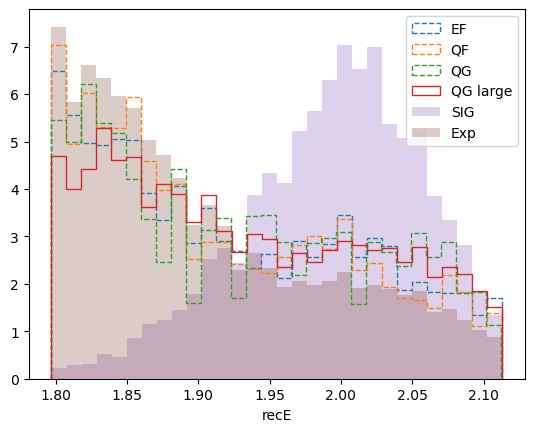

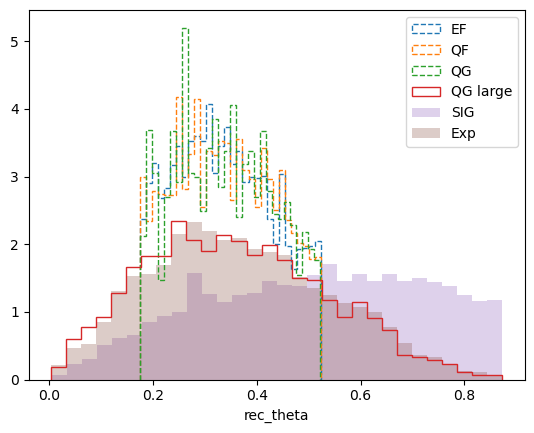

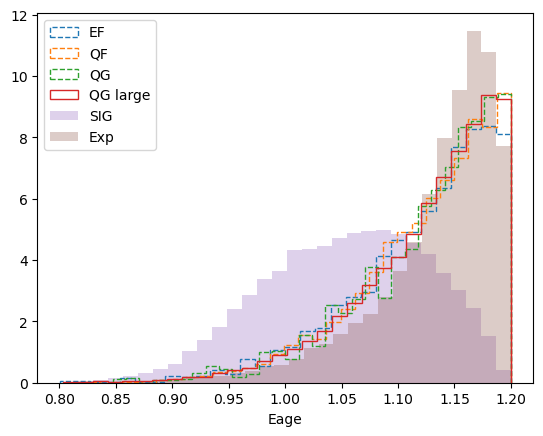

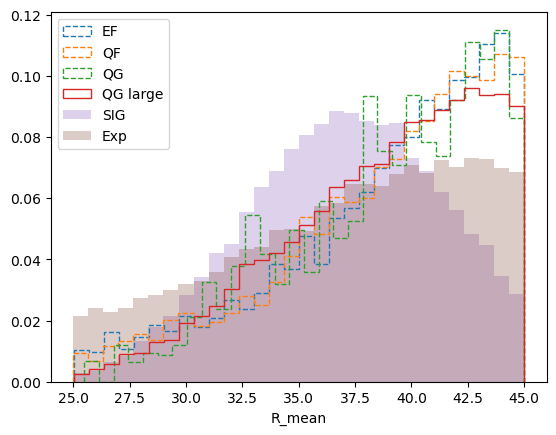

In [18]:
# 分析参数
import numpy as np
import pandas as pd
import json
import os
import uproot
# =====================================================
# 1. IO 工具
# =====================================================

def read_csv_df(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df=pd.read_csv(path)
    df['weight']=np.ones(len(df))
    return df


def read_val_scores_new(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    data= pd.read_csv(path)
    sig_data=data[data['label']==43]
    bkg_data=data[data['label']==14]
    return sig_data, bkg_data


def give_weights(params_df):
    rootfile = "/home/zhonghua/data/exposure.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE = np.asarray(trueE, dtype=float)
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1 
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        
        return weights_2d[bin_idx_E, bin_idx_Zen] / 10 
    trueE = params_df['trueE'].values
    rec_zenith = params_df['theta'].values
    weights = add_weights(trueE, rec_zenith, weights_2d)
    params_df['weight'] = weights
    return params_df

def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/Filt_Event/model_validation/exposure.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)

    monopole_df["weight"] = monopole_weights
    return monopole_df

# =====================================================
# 2. 配置
# =====================================================

base_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"

EF_csv = f"{base_dir}/EF_Model_xgb.csv"
QF_csv = f"{base_dir}/QF_Model_xgb.csv"
QG_csv_large = f"{base_dir}/QG_large_xgb.csv"
val_npz = f"{base_dir}/validation_set_xgb.csv"
exp_2022_csv = f"{base_dir}/Exp_2022_xgb.csv"
exp_2022_csv = f"{base_dir}/Exp_2022_xgb.csv"
large_sig_csv = f"{base_dir}/Monopole_large_xgb.csv"

# =====================================================
# 3. 构建直方图
# =====================================================
# diff model EF+QF 
EF_scores  = read_csv_df(EF_csv)
QF_scores  = read_csv_df(QF_csv)
EF_scores = give_weights(EF_scores)
QF_scores = give_weights(QF_scores)
QG_scores_large  = read_csv_df(QG_csv_large)
QG_scores_large = give_weights(QG_scores_large)
# exp data
exp_2022_scores = read_csv_df(exp_2022_csv)
# val data
sig_scores, bkg_scores = read_val_scores_new(val_npz)
bkg_scores = give_weights(bkg_scores)
# large sig score
sig_scores = read_csv_df(large_sig_csv)
sig_scores = give_sig_weights(sig_scores)
# =====================================================
# 4. 绘图
# =====================================================
bins=30
# recE 
plt.hist(EF_scores["recE"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["recE"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["recE"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["recE"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["recE"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["recE"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3,label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("recE")
plt.show()
# rec_theta
plt.hist(EF_scores["rec_theta"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["rec_theta"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["rec_theta"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["rec_theta"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["rec_theta"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["rec_theta"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3,label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("rec_theta")
plt.show()
# Eage
plt.hist(EF_scores["Eage"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["Eage"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["Eage"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["Eage"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["Eage"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["Eage"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3,label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("Eage")
plt.show()
# R_mean
plt.hist(EF_scores["R_mean"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["R_mean"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["R_mean"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["R_mean"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["R_mean"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["R_mean"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled',alpha=0.3, label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("R_mean")
plt.show()
